In [1]:
import pandas as pd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature


/var/folders/77/zy4m_x5572z29138mf399bxr0000gp/T/ipykernel_57011/585130713.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
path_to_isp = '/Users/pmanshausen/Documents/rain_gauges/data/3611864.csv'

In [3]:
stations = pd.read_csv(path_to_isp)

/var/folders/77/zy4m_x5572z29138mf399bxr0000gp/T/ipykernel_57011/3940947570.py:1: DtypeWarning: Columns (0,6,10) have mixed types. Specify dtype option on import or set low_memory=False.
  stations = pd.read_csv(path_to_isp)


In [4]:
import numpy as np
def extract_gust_speed(x):
    if type(x)==str:
        if float(x.split(',')[0]) == 9999: return np.nan
        else: return float(x.split(',')[0])
    else: return np.nan

In [5]:
stations['gust'] = stations.OC1.map(extract_gust_speed)

In [6]:
stations['DATE'] = pd.to_datetime(stations.DATE)

In [7]:
stations_17 = stations.loc[stations.DATE.dt.year == 2017]

In [8]:
stations_17.dropna(subset = ['gust'], inplace=True)

/var/folders/77/zy4m_x5572z29138mf399bxr0000gp/T/ipykernel_57011/1643502930.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stations_17.dropna(subset = ['gust'], inplace=True)


In [9]:
projection = ccrs.LambertConformal(central_longitude=262.5, 
                                   central_latitude=38.5, 
                                   standard_parallels=(38.5, 38.5),
                                    globe=ccrs.Globe(semimajor_axis=6371229,
                                                     semiminor_axis=6371229))
def lonlat_to_xy(projection, longitude, latitude):
    x, y = projection.transform_point(longitude, latitude, ccrs.PlateCarree())
    xmin = -2697520.142522
    x_dist = 3000.
    ymin = -1587306.152557
    y_dist = 3000.
    
    x = (x-xmin)/x_dist
    y = (y-ymin)/y_dist
    return x,y

def latlon_to_xy_wrapper(row):
    x, y = lonlat_to_xy(projection, row['LONGITUDE'], row['LATITUDE'])
    return x, y

# Apply the function to each row of the DataFrame
stations_17[['x', 'y']] = stations_17.apply(latlon_to_xy_wrapper, axis=1, result_type='expand')


/var/folders/77/zy4m_x5572z29138mf399bxr0000gp/T/ipykernel_57011/2462265107.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stations_17[['x', 'y']] = stations_17.apply(latlon_to_xy_wrapper, axis=1, result_type='expand')
/var/folders/77/zy4m_x5572z29138mf399bxr0000gp/T/ipykernel_57011/2462265107.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stations_17[['x', 'y']] = stations_17.apply(latlon_to_xy_wrapper, axis=1, result_type='expand')


In [188]:
df = stations_17[['DATE','gust', 'x', 'y']]

In [190]:
# Get unique values of 'x' and 'y'
unique_x_values = df['x'].unique()
unique_y_values = df['y'].unique()
unique_combinations = df[['x', 'y']].drop_duplicates()

In [234]:

# Get unique values of 'x' and 'y'
unique_x_values = np.arange(unique_combinations['x'].min(), unique_combinations['x'].max() + 1)
unique_y_values = np.arange(unique_combinations['y'].min(), unique_combinations['y'].max() + 1)

# Create an empty xarray DataArray with all zeros
data_array = xr.DataArray(np.zeros((len(unique_y_values), len(unique_x_values))), 
                          coords={'y': unique_y_values, 'x': unique_x_values}, 
                          dims=['y', 'x'])

# Loop through each unique combination and update the entries of the xarray DataArray
for _, row in unique_combinations.iterrows():
    data_array.loc[row['y'], row['x']] = 1

# Display the resulting DataArray
print(data_array)

<xarray.DataArray (y: 124, x: 122)> Size: 121kB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * y        (y) float64 992B 357.0 358.0 359.0 360.0 ... 478.0 479.0 480.0
  * x        (x) float64 976B 839.0 840.0 841.0 842.0 ... 958.0 959.0 960.0


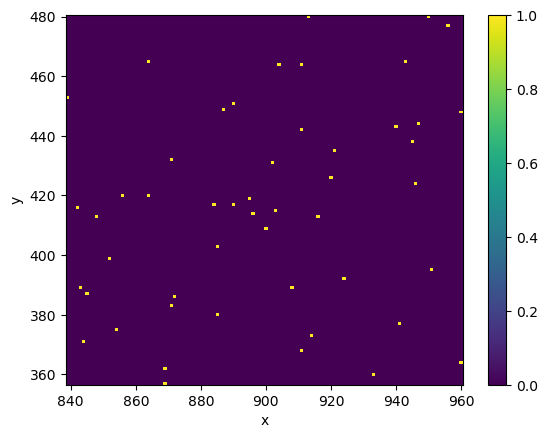

In [235]:
data_array.plot()

In [11]:
import pandas as pd
from itertools import product


In [184]:
df['DATE'] = pd.to_datetime(df['DATE'])

# Step 2: Group DataFrame by station and interpolate 'gust' values
df_interpolated = df.groupby(['x', 'y', pd.Grouper(freq='H', key='DATE')]).mean().apply(lambda group: group.interpolate(limit=1))

# Step 3: Create a new DataFrame with timestamps at full hours
full_hours = pd.date_range(start=df_interpolated.index.get_level_values('DATE').min().floor('H'), 
                           end=df_interpolated.index.get_level_values('DATE').max().ceil('H'), 
                           freq='H')

# Create Cartesian product of 'DATE', 'x', and 'y' values
cartesian_product = list(product(full_hours, df_interpolated.index.levels[0], df_interpolated.index.levels[1]))

# Step 4: Merge interpolated gust values with new DataFrame using full hour timestamps
df_final = pd.DataFrame(cartesian_product, columns=['DATE', 'x', 'y'])
df_final = df_final.merge(df_interpolated.reset_index(), on=[ 'x', 'y','DATE',], how='left')

# # Reset index and drop multi-index
# df_final.reset_index(drop=True, inplace=True)

# # Display the resulting DataFrame
# print(df_final)

/var/folders/77/zy4m_x5572z29138mf399bxr0000gp/T/ipykernel_57011/1269335292.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DATE'] = pd.to_datetime(df['DATE'])
/var/folders/77/zy4m_x5572z29138mf399bxr0000gp/T/ipykernel_57011/1269335292.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_interpolated = df.groupby(['x', 'y', pd.Grouper(freq='H', key='DATE')]).mean().apply(lambda group: group.interpolate(limit=1))
/var/folders/77/zy4m_x5572z29138mf399bxr0000gp/T/ipykernel_57011/1269335292.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_hours = pd.date_range(start=df_interpolated.index.get_level_values('DATE').min().floor('H

In [239]:
stations_17

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,SOURCE,REPORT_TYPE,CALL_SIGN,QUALITY_CONTROL,AA1,OC1,TMP,WND,gust,x,y
20,72352603932,"CLINTON SHERMAN AIRPORT, OK US",35.35680,-99.2042,585.8,2017-01-01 18:53:00,7,FM-15,KCSM,V030,"01,0000,9,5","0088,5","+0117,5","200,5,N,0062,5",88.0,847.581909,413.015020
21,72352603932,"CLINTON SHERMAN AIRPORT, OK US",35.35680,-99.2042,585.8,2017-01-01 19:53:00,7,FM-15,KCSM,V030,"01,0000,9,5","0098,5","+0128,5","190,5,N,0062,5",98.0,847.581909,413.015020
75,72352603932,"CLINTON SHERMAN AIRPORT, OK US",35.35680,-99.2042,585.8,2017-01-03 09:53:00,7,FM-15,KCSM,V030,"01,0000,9,5","0129,5","+0033,5","360,5,N,0088,5",129.0,847.581909,413.015020
79,72352603932,"CLINTON SHERMAN AIRPORT, OK US",35.35680,-99.2042,585.8,2017-01-03 13:53:00,7,FM-15,KCSM,V030,"01,0000,9,5","0144,5","+0000,5","340,5,N,0108,5",144.0,847.581909,413.015020
80,72352603932,"CLINTON SHERMAN AIRPORT, OK US",35.35680,-99.2042,585.8,2017-01-03 14:53:00,7,FM-15,KCSM,V030,"01,0000,9,5","0139,5","-0006,5","340,5,N,0108,5",139.0,847.581909,413.015020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5676132,72209953936,"CHANDLER MUNICIPAL AIRPORT, OK US",35.72361,-96.8200,299.9,2017-12-31 21:35:00,4,FM-15,99999,V020,NaN,"0088,1","-0061,1","350,1,N,0062,1",88.0,919.659517,426.227285
5676134,72209953936,"CHANDLER MUNICIPAL AIRPORT, OK US",35.72361,-96.8200,299.9,2017-12-31 22:15:00,4,FM-15,99999,V020,NaN,"0088,1","-0065,1","360,1,N,0057,1",88.0,919.659517,426.227285
5676135,72209953936,"CHANDLER MUNICIPAL AIRPORT, OK US",35.72361,-96.8200,299.9,2017-12-31 22:35:00,4,FM-15,99999,V020,NaN,"0098,1","-0071,1","350,1,N,0062,1",98.0,919.659517,426.227285
5676136,72209953936,"CHANDLER MUNICIPAL AIRPORT, OK US",35.72361,-96.8200,299.9,2017-12-31 22:55:00,4,FM-15,99999,V020,NaN,"0088,1","-0080,1","360,1,N,0051,1",88.0,919.659517,426.227285


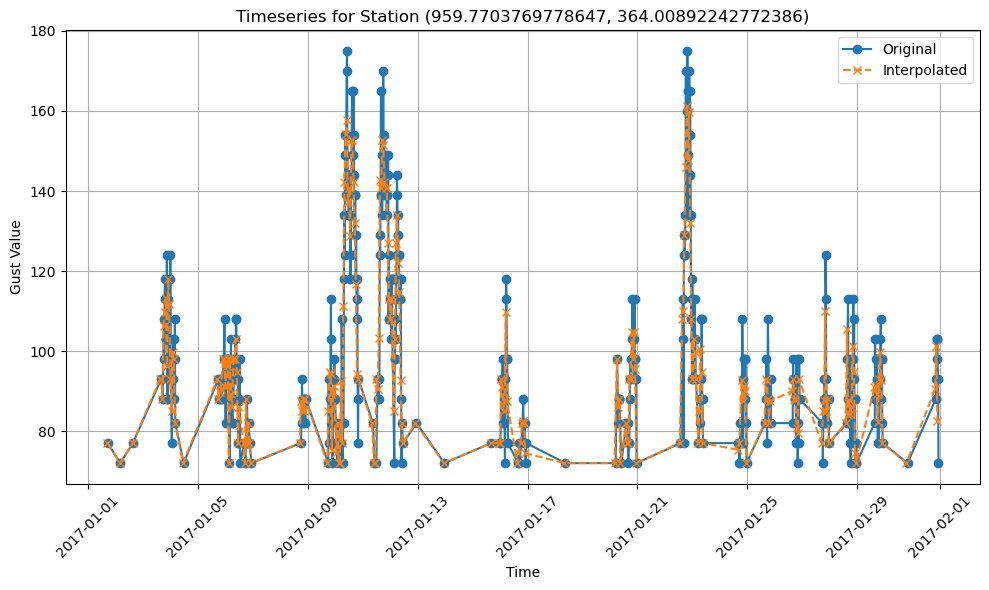

In [13]:
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame with columns 'DATE', 'x', 'y', and 'gust'
# Also assuming 'df_interpolated' is the DataFrame with interpolated gust values

# Choose a specific station (x, y) to plot
x_station = 959.7703769778647  # Replace with the x-coordinate of your chosen station
y_station = 364.00892242772386  # Replace with the y-coordinate of your chosen station

# Select data for the chosen station
original_data = df[(df['x'] == x_station) & (df['y'] == y_station)].loc[df.DATE.dt.month == 1]
interpolated_data = df_interpolated[(df_interpolated.index.get_level_values('x') == x_station) & (df_interpolated.index.get_level_values('y') == y_station)&(df_interpolated.index.get_level_values('DATE').month == 1)]

# Plot timeseries
plt.figure(figsize=(10, 6))
plt.plot(original_data['DATE'], original_data['gust'], label='Original', marker='o')
plt.plot(interpolated_data.index.get_level_values('DATE'), interpolated_data['gust'], label='Interpolated', linestyle='--', marker='x')
plt.xlabel('Time')
plt.ylabel('Gust Value')
plt.title(f'Timeseries for Station ({x_station}, {y_station})')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

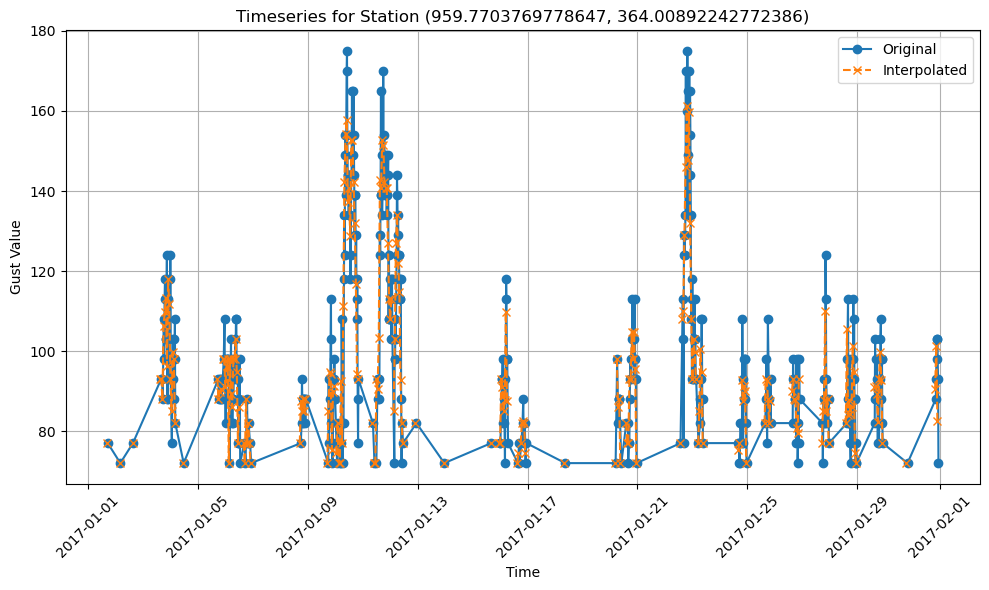

In [14]:

# Assuming 'df' is your DataFrame with columns 'DATE', 'x', 'y', and 'gust'
# Also assuming 'df_interpolated' is the DataFrame with interpolated gust values

# Choose a specific station (x, y) to plot
x_station = 959.7703769778647  # Replace with the x-coordinate of your chosen station
y_station = 364.00892242772386  # Replace with the y-coordinate of your chosen station

# Select data for the chosen station
original_data = df[(df['x'] == x_station) & (df['y'] == y_station)].loc[df.DATE.dt.month == 1]
interpolated_data = df_final[(df_final['x'] == x_station) & (df_final['y'] == y_station)&(df_final['DATE'].dt.month == 1)]

# Plot timeseries
plt.figure(figsize=(10, 6))
plt.plot(original_data['DATE'], original_data['gust'], label='Original', marker='o')
plt.plot(interpolated_data['DATE'], interpolated_data['gust'], label='Interpolated', linestyle='--', marker='x')
plt.xlabel('Time')
plt.ylabel('Gust Value')
plt.title(f'Timeseries for Station ({x_station}, {y_station})')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [172]:
df_final.set_index([ 'x', 'y','DATE',], inplace=True)

In [179]:

df_final['x'] = df_final.x.round()
df_final['y'] = df_final.y.round()

In [185]:
df_final

,DATE,x,y,gust
0,2017-01-01 03:00:00,838.877622,356.719266,NaN
1,2017-01-01 03:00:00,838.877622,360.191057,NaN
2,2017-01-01 03:00:00,838.877622,361.503961,NaN
3,2017-01-01 03:00:00,838.877622,364.008922,NaN
4,2017-01-01 03:00:00,838.877622,367.620826,NaN
...,...,...,...,...
21892495,2017-12-31 23:00:00,959.770377,465.255172,NaN
21892496,2017-12-31 23:00:00,959.770377,465.301909,NaN
21892497,2017-12-31 23:00:00,959.770377,477.475160,NaN
21892498,2017-12-31 23:00:00,959.770377,479.761941,NaN


In [183]:
df_final

,DATE,x,y,gust
0,2017-01-01 03:00:00,839.0,357.0,NaN
1,2017-01-01 03:00:00,839.0,360.0,NaN
2,2017-01-01 03:00:00,839.0,362.0,NaN
3,2017-01-01 03:00:00,839.0,364.0,NaN
4,2017-01-01 03:00:00,839.0,368.0,NaN
...,...,...,...,...
21892495,2017-12-31 23:00:00,960.0,465.0,NaN
21892496,2017-12-31 23:00:00,960.0,465.0,NaN
21892497,2017-12-31 23:00:00,960.0,477.0,NaN
21892498,2017-12-31 23:00:00,960.0,480.0,NaN


In [147]:
# df=df_final

# # Convert the float x and y values to integers
# df['x'] = df.index.get_level_values('x').astype(int)
# df['y'] = df.index.get_level_values('y').astype(int)

# # Create regular x and y coordinates
# x_coords = np.arange(df['x'].min(), df['x'].max() + 1)
# y_coords = np.arange(df['y'].min(), df['y'].max() + 1)

# # Create a grid of all combinations of x and y coordinates
# grid = pd.MultiIndex.from_product([x_coords, y_coords], names=['x', 'y'])

# # Resample the DataFrame to the regular grid
# df_resampled = df.reset_index().set_index(['x', 'y']).reindex(grid).reset_index()

# # Convert the resampled DataFrame to an xarray DataSet
# ds = df_resampled.set_index(['x', 'y', 'date']).to_xarray()

# # Display the resulting DataSet
# print(ds)

In [173]:
stations_naive_grid = df_final.to_xarray()

ValueError: cannot convert a DataFrame with a non-unique MultiIndex into xarray

In [154]:
import xarray as xr

# Assuming 'ds' is your xarray dataset

# Group by x and y coordinates and aggregate by mean
ds = stations_naive_grid

# Define the integer x and y positions
x_int = np.arange(ds['x'].min().round(), ds['x'].max().round() + 1)
y_int = np.arange(ds['y'].min().round(), ds['y'].max().round() + 1)

# Create a new dataset with integer x and y positions
ds_regrid = xr.Dataset(coords={'x': x_int, 'y': y_int})

# Interpolate the original dataset to the new integer x-y grid
ds_interp = ds.interp(x=x_int, y=y_int, method='nearest')

# Use combine_first to ensure that each grid cell has only one value
ds_regrid['gust'] = ds_interp['gust'].combine_first(ds['gust'])

# Display the regridded dataset
print(ds_regrid)

<xarray.Dataset> Size: 1GB
Dimensions:  (x: 122, y: 124, DATE: 8757)
Coordinates:
  * x        (x) float64 976B 839.0 840.0 841.0 842.0 ... 958.0 959.0 960.0
  * y        (y) float64 992B 357.0 358.0 359.0 360.0 ... 478.0 479.0 480.0
  * DATE     (DATE) datetime64[ns] 70kB 2017-01-01T03:00:00 ... 2017-12-31T23...
Data variables:
    gust     (x, y, DATE) float64 1GB nan nan nan nan nan ... nan nan nan nan


In [159]:
ds_regrid

<xarray.Dataset> Size: 1GB
Dimensions:  (x: 122, y: 124, DATE: 8757)
Coordinates:
  * x        (x) float64 976B 839.0 840.0 841.0 842.0 ... 958.0 959.0 960.0
  * y        (y) float64 992B 357.0 358.0 359.0 360.0 ... 478.0 479.0 480.0
  * DATE     (DATE) datetime64[ns] 70kB 2017-01-01T03:00:00 ... 2017-12-31T23...
Data variables:
    gust     (x, y, DATE) float64 1GB nan nan nan nan nan ... nan nan nan nan

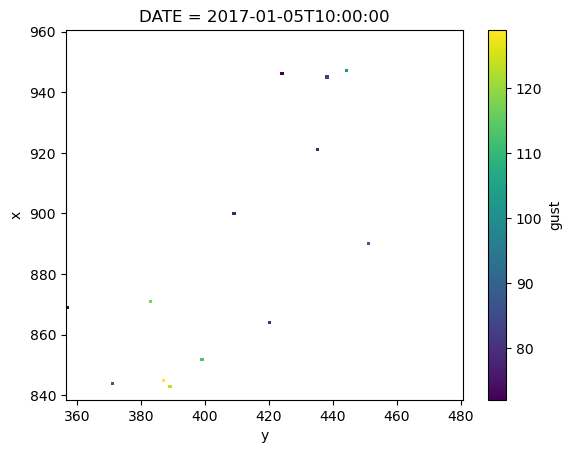

In [236]:
ds_regrid.isel({'DATE':103}).where(data_array==1).gust.plot.imshow()

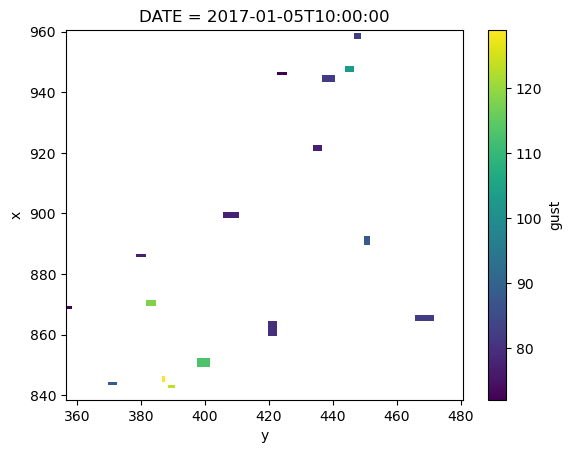

In [238]:
ds_regrid.isel({'DATE':103}).gust.plot.imshow()

In [21]:
# pd.set_option('display.max_columns', 120, 'display.max_rows', 120)


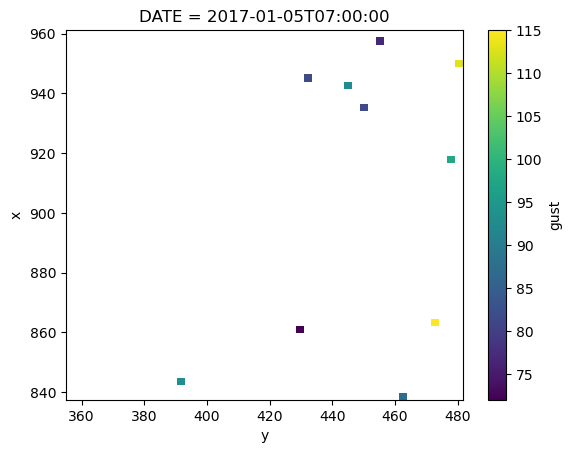

In [22]:
stations_naive_grid.isel({'DATE':100}).gust.plot.imshow()

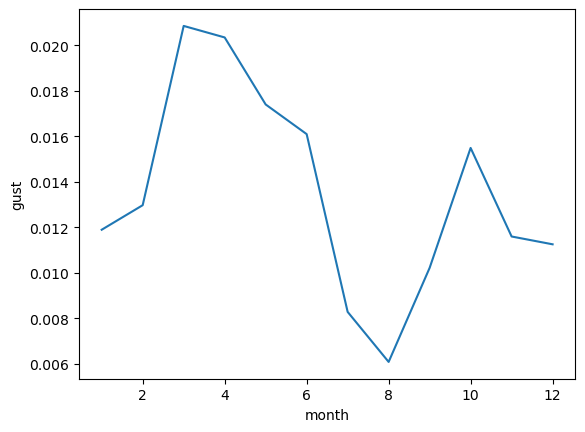

In [241]:
(ds_regrid.gust.where(data_array==1).groupby(ds_regrid['DATE'].dt.month,squeeze=False).count().mean(['x','y'])/30).plot()

Text(0, 0.5, 'fraction of pixels with data')

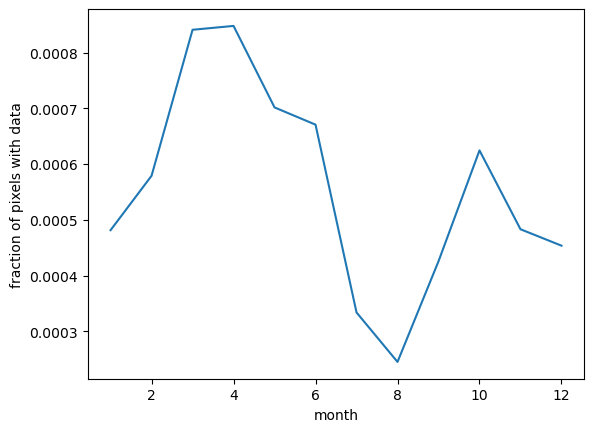

In [252]:
ds_regrid.gust.where(data_array==1).groupby(ds_regrid['DATE'],squeeze=False).count().mean(['x','y']).groupby(ds_regrid['DATE'].dt.month).mean().plot()
plt.ylabel('fraction of pixels with data')

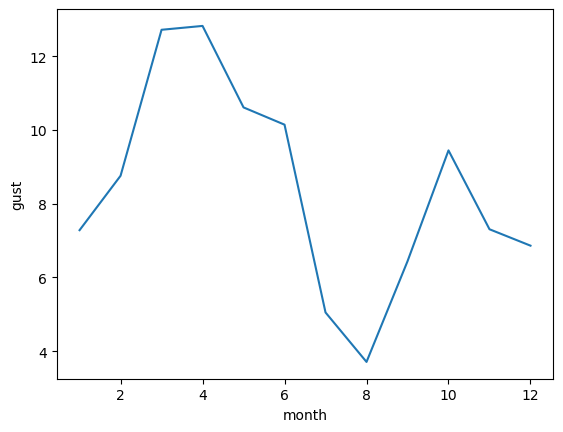

In [255]:
ds_regrid.gust.where(data_array==1).groupby(ds_regrid['DATE'],squeeze=False).count().sum(['x','y']).groupby(ds_regrid['DATE'].dt.month).mean().plot()

Text(0, 0.5, 'number of stations reporting')

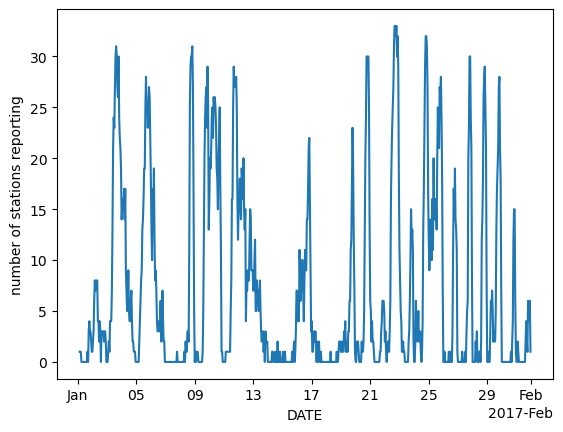

In [260]:
ds_regrid.gust.where((data_array==1) &(ds_regrid['DATE'].dt.month ==1)).groupby(ds_regrid['DATE'],squeeze=False).count().sum(['x','y']).loc[(ds_regrid['DATE'].dt.month ==1)].plot()
plt.ylabel('number of stations reporting')

In [261]:
import cartopy.crs as ccrs
 

projection = ccrs.LambertConformal(central_longitude=262.5, 
                                   central_latitude=38.5, 
                                   standard_parallels=(38.5, 38.5),
                                    globe=ccrs.Globe(semimajor_axis=6371229,
                                                     semiminor_axis=6371229))
def lonlat_to_xy(projection, longitude, latitude):
    x, y = projection.transform_point(longitude, latitude, ccrs.PlateCarree())
    xmin = -2697520.142522
    x_dist = 3000.
    ymin = -1587306.152557
    y_dist = 3000.
    
    x = (x-xmin)/x_dist
    y = (y-ymin)/y_dist
    return x,y


In [262]:
min_lat, max_lat, min_lon, max_lon = (33.737870270270264, 37.19732972972973, -99.64021725759747, -95.39258274240254)

In [269]:
print(lonlat_to_xy(projection, min_lon, min_lat))
print(lonlat_to_xy(projection, max_lon, min_lat))
print(lonlat_to_xy(projection, max_lon, max_lat))
print(lonlat_to_xy(projection, min_lon, max_lat))

(832.9858722325639, 353.15672416814425)
(964.346708332245, 353.1333176566468)
(961.4064122885709, 481.52523593060585)
(835.9719230786895, 481.54758645684365)


In [265]:
lonlat_to_xy(projection, max_lon, min_lat)

(964.346708332245, 353.1333176566468)

In [273]:
961.4064122885709 - 835.9719230786895

125.43448920988135

In [274]:
962-834

128

In [275]:
481-353

128